# Auditing Bias of Machine Learning Algorithms

In this tutorial, we audit a machine learning model in terms of its fairness property. Our focus is on group fairness, a popular paradigm of fairness notions that try to establish equity in prediction across different demographic groups in the data based on sensitive features: race, gender, etc. By the end of this notebook, the audience will be demonstrated a formal framework for quantifying bias or unfairness in machine learning and a framework to explain bias in terms of participating feature combinations in the data.
- **Formal Quantification of Bias:** We deploy a recently developed formal fairness quantifier `Justicia` to quantify the bias of a machine learning classifier that relies on the probability distribution of features to measure the bias of the classifier. (https://github.com/meelgroup/justicia)
- **Fairness Enhancing Algorithms** We demonstrate to improve unfairness by applying a pre-processing *reweighing*-based fairness algorithms from AIF360, an extensive library of fairness algorithms (https://github.com/ReAILe/bias-explainer)
- **Explaining Sources of Bias:** We rely on a fairness explainer, called `FairXplainer` to decompose the bias of the classifier among unfairness contributions of different combinations of features. (https://github.com/ReAILe/bias-explainer)
- For experiments, we consider recently introduced US census datasets incorporated in a python package `folktables`. The details of the dataset is here: https://github.com/socialfoundations/folktables

In [1]:
# Necessary libraries (see README.md for installation instructions)
from folktables import ACSDataSource, ACSEmployment, generate_categories
import math
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from justicia.metrics import Metric
import aif360
from sklearn import svm
from aif360.algorithms.preprocessing import DisparateImpactRemover
from aif360.algorithms.preprocessing.reweighing import Reweighing
from fairxplainer.fair_explainer import FairXplainer
from fairxplainer.fair_explainer import plot as fif_plot
from fairxplainer import utils
from sklearn.metrics import classification_report



fontsize = 22
labelsize = 20



good_name_features = {
        'AGEP' : 'Age',
        'SCHL' : 'Education',
        'MAR' : 'Marital_status',
        'RELP' : 'Relationship',
        'DIS' : 'Disability',
        'ESP' : "Parent's_employment",
        'CIT' : 'Citizenship',
        'MIG' : 'Mobility_status',
        'MIL' : 'Military_service',
        'ANC' : 'Ancestry',
        'NATIVITY' : 'Nativity',
        'DEAR' : 'Hearing_difficulty',
        'DEYE' : 'Vision_difficulty',
        'DREM' : 'Cognitive_difficulty',
        'SEX' : 'Sex',
        'RAC1P' : 'Race'
}

/Users/bishwamittraghosh/mambaforge-pypy3/envs/fairness_tutorial/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
pip install 'aif360[LawSchoolGPA]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'


Get the dataset

In [2]:
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
definition_df = data_source.get_definitions(download=True)
acs_data = data_source.get_data(states=["AL"], download=True)
features_unscaled, label, group = ACSEmployment.df_to_pandas(acs_data)
categories_ = generate_categories(features=features_unscaled, definition_df=definition_df)
categories = {}
for key in categories_.keys():    
    categories[good_name_features[key]] = categories_[key]
features_unscaled = features_unscaled.rename(columns=good_name_features)
features_unscaled.shape

(47777, 16)

In [3]:
features_unscaled.drop(['Citizenship', 'Ancestry', 'Nativity', "Parent's_employment"], axis=1, inplace=True)
flag = (20 <= features_unscaled['Age']) & (features_unscaled['Age'] <= 60)
# flag = (features_unscaled['Age'] <= 60)
label = label[flag]
# features_unscaled = features_unscaled[(20 <= features_unscaled['Age']) & (features_unscaled['Age'] <= 60)]
features_unscaled = features_unscaled[flag]
features_unscaled.shape, label.shape

((23793, 12), (23793, 1))

In [4]:
# label = label.drop(features_unscaled[features_unscaled['Race'].isin([3, 4, 5, 7, 8])].index)
# features_unscaled = features_unscaled.drop(features_unscaled[features_unscaled['Race'].isin([3, 4, 5, 7, 8])].index)
# label.reset_index(drop=True, inplace=True)
# features_unscaled.reset_index(drop=True, inplace=True)

# categories['Race'] = {
#     1: 'White alone',
#     2: 'Black or African American alone',
#     3: 'Others',
# }
# features_unscaled['Race'] = features_unscaled.apply(lambda x: x['Race'] if x['Race'] in [1, 2] else 3, axis=1)


In [5]:
feature_to_one_hot_encode = "Marital_status"
# feature_to_one_hot_encode = "Race"
# feature_to_one_hot_encode = 'Citizenship'
features_unscaled = features_unscaled.replace({feature_to_one_hot_encode : categories[feature_to_one_hot_encode]}) 
features_unscaled = utils.get_one_hot_encoded_df(features_unscaled, [feature_to_one_hot_encode]) 
for key in categories[feature_to_one_hot_encode]:
    val = categories[feature_to_one_hot_encode][key]
    categories[f'{feature_to_one_hot_encode}_' + val] = {1 : 'Yes', 0 : 'No'}
del categories[feature_to_one_hot_encode]

In [6]:
features_unscaled['Age'].describe()

count    23793.000000
mean        41.315093
std         12.168604
min         20.000000
25%         31.000000
50%         42.000000
75%         52.000000
max         60.000000
Name: Age, dtype: float64

In [7]:
features_unscaled['Age_less_than_30'] = features_unscaled['Age'] < 30
features_unscaled['Age_between_30_and_40'] = (features_unscaled['Age'] >= 30) & (features_unscaled['Age'] < 40)
features_unscaled['Age_between_40_and_50'] = (features_unscaled['Age'] >= 40) & (features_unscaled['Age'] < 50)
features_unscaled['Age_greater_than_50'] = features_unscaled['Age'] >= 50
features_unscaled.drop('Age', axis=1, inplace=True)

Scale dataset

In [8]:
scaler = MinMaxScaler()
features = features_unscaled.copy()
features[features.columns] = scaler.fit_transform(features[features.columns])
features

,Education,Relationship,Disability,Mobility_status,Military_service,Hearing_difficulty,Vision_difficulty,Cognitive_difficulty,Sex,Race,Marital_status_Divorced,Marital_status_Married,Marital_status_Never married or under 15 years old,Marital_status_Separated,Marital_status_Widowed,Age_less_than_30,Age_between_30_and_40,Age_between_40_and_50,Age_greater_than_50
2,0.695652,0.941176,0.0,0.0,1.000000,1.0,1.0,0.0,0.0,0.000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.782609,0.941176,1.0,0.0,0.333333,1.0,1.0,1.0,0.0,0.000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.478261,0.941176,0.0,1.0,1.000000,1.0,1.0,0.0,1.0,0.000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
5,0.652174,0.941176,0.0,0.0,1.000000,1.0,1.0,0.0,1.0,0.000,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
7,0.478261,0.941176,0.0,0.0,1.000000,0.0,1.0,1.0,0.0,0.000,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47758,0.826087,0.000000,1.0,0.0,1.000000,1.0,1.0,1.0,1.0,0.000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
47759,0.652174,0.058824,1.0,0.0,1.000000,1.0,1.0,1.0,0.0,0.000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
47762,0.782609,0.235294,1.0,0.0,1.000000,1.0,1.0,1.0,0.0,0.000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
47765,0.652174,0.117647,1.0,0.0,1.000000,1.0,1.0,1.0,1.0,0.125,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Interpreting feature values

In [9]:
# mapping categories from unscaled to scaled
assert isinstance(scaler, MinMaxScaler)
categories_scaled = {}

for column in features_unscaled.columns:
    categories_scaled[column] = {}
    idx = list(features_unscaled.columns).index(column)
    if(column not in categories):
        continue
    for key in categories[column].keys():
        if(not math.isnan(key)):
            categories_scaled[column][key * scaler.scale_[idx] + scaler.min_[idx]] = categories[column][key]

Training

In [10]:
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.4, random_state=0)

model, model_name = LogisticRegression(solver='lbfgs', max_iter=10000), "lr"
# model, model_name = svm.SVC(kernel='linear'), "svm"
model.fit(X_train, y_train)


/Users/bishwamittraghosh/mambaforge-pypy3/envs/fairness_tutorial/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(max_iter=10000)

In [11]:
yhat = model.predict(X_test)
print(classification_report(y_test, yhat, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.71      0.43      0.54      3053
           1       0.77      0.92      0.84      6465

    accuracy                           0.76      9518
   macro avg       0.74      0.67      0.69      9518
weighted avg       0.75      0.76      0.74      9518



In [12]:
for sensitive_feature_set in X_test.columns:
    sensitive_feature_set = [sensitive_feature_set]
    fairXplainer = FairXplainer(model, X_test, sensitive_feature_set)
    fairXplainer.compute(compute_sp_only=True)
    print(sensitive_feature_set, fairXplainer.statistical_parity_sample(verbose=False))

['Education'] 0.9900990099009901
['Relationship'] 0.7788460933023543
['Disability'] 0.795805820644365
['Mobility_status'] 0.12486799094795076
['Military_service'] 0.08294930875576034
['Hearing_difficulty'] 0.31319982773471144
['Vision_difficulty'] 0.62758582441351
['Cognitive_difficulty'] 0.835100612745474
['Sex'] 0.04262077841448153
['Race'] 0.4285714285714286
['Marital_status_Divorced'] 0.09768701311933703
['Marital_status_Married'] 0.205947156901077
['Marital_status_Never married or under 15 years old'] 0.14608075306376178
['Marital_status_Separated'] 0.2254663897096828
['Marital_status_Widowed'] 0.21304808367532868
['Age_less_than_30'] 0.008227374577265412
['Age_between_30_and_40'] 0.04774812289522978
['Age_between_40_and_50'] 0.045727928055963596
['Age_greater_than_50'] 0.06786312084068324


In [13]:
# for sensitive_feature_set in [['Sex'], ['Race'], ['Sex', 'Race']]:
# for sensitive_feature_set in [['Sex'], ['Marital_status'], ['Sex', 'Marital_status']]:
for sensitive_feature_set in [['Sex'], ['Sex', 'Age'], ['Marital_status', 'Sex']]:
# for sensitive_feature_set in [['Sex'], ['Disability'], ['Sex', 'Disability']]:
# for sensitive_feature_set in X_test.columns:
#     if(sensitive_feature_set in ['Age', 'Education']):
#         continue
#     sensitive_feature_set = [sensitive_feature_set]
    fairXplainer = FairXplainer(model, X_test, sensitive_feature_set)
    fairXplainer.compute(compute_sp_only=True)
    print(sensitive_feature_set)
    fairXplainer.statistical_parity_sample(verbose=True)

['Sex']
Positive prediction rate of sensitive groups:
{'Sex = 0.0': 0.8272552783109405, 'Sex = 1.0': 0.784634499896459}
Empirical statistical parity: 0.04262077841448153
['Sex', 'Age']
Positive prediction rate of sensitive groups:
{'Sex = 0.0, Age_less_than_30 = 0.0, Age_between_30_and_40 = 0.0, Age_between_40_and_50 = 0.0, Age_greater_than_50 = 1.0': 0.7862957937584804,
 'Sex = 0.0, Age_less_than_30 = 0.0, Age_between_30_and_40 = 0.0, Age_between_40_and_50 = 1.0, Age_greater_than_50 = 0.0': 0.8587360594795539,
 'Sex = 0.0, Age_less_than_30 = 0.0, Age_between_30_and_40 = 1.0, Age_between_40_and_50 = 0.0, Age_greater_than_50 = 0.0': 0.8338164251207729,
 'Sex = 0.0, Age_less_than_30 = 1.0, Age_between_30_and_40 = 0.0, Age_between_40_and_50 = 0.0, Age_greater_than_50 = 0.0': 0.845108695652174,
 'Sex = 1.0, Age_less_than_30 = 0.0, Age_between_30_and_40 = 0.0, Age_between_40_and_50 = 0.0, Age_greater_than_50 = 1.0': 0.7356037151702787,
 'Sex = 1.0, Age_less_than_30 = 0.0, Age_between_30_and

## Formal fairness quantification

In [14]:
justicia_results = []

# for sensitive_feature_set in [['Sex'], ['Race'], ['Race', 'Sex']]:
# for sensitive_feature_set in [['Sex'], ['Marital_status'], ['Marital_status', 'Sex']]:
for sensitive_feature_set in [['Sex'], ['Sex', 'Age'], ['Marital_status', 'Sex']]:
# for sensitive_feature_set in [['Sex'], ['Disability'], ['Sex', 'Disability']]:

    print("Sensitive features", sensitive_feature_set)
    metric = Metric(model=model, 
                    data=X_test, 
                    sensitive_attributes=sensitive_feature_set,
                    verbose=False,
                    discretization_bins=10,
                    encoding="best",
                    dag_threshold=0.6,
                    dag_filename=f"dag_{model_name}_" + "_".join(sensitive_feature_set) +".pkl")
    metric.compute()
    # print("Sensitive attributes", metric.given_sensitive_attributes)
    # print("Disparate Impact:", metric.disparate_impact_ratio)
    # print("Statistical Parity:", metric.statistical_parity_difference)
    # print("Time taken", metric.time_taken, "seconds")
    print(metric)
    print()
    justicia_results.append(metric)
    



Sensitive features ['Sex']

Justicia
 - encoding: Learn-efficient
 - model: LogisticRegression(max_iter=10000)
 - given_sensitive_attributes: ['Sex']
 - sensitive_group_statistics: [([('Sex', ('!=', 1.0))], 0.6500785431071616, 45, 0), ([('Sex', ('==', 1.0))], 0.5873913872877335, 45, 0)]
 - given_mediator_attributes: []
 - given_major_group: {}
 - time_taken: 0.7291059494018555
 - most_favored_group: {'Sex': ('!=', 1.0)}
 - least_favored_group: {'Sex': ('==', 1.0)}
 - statistical_parity_difference: 0.06268715581942808
 - disparate_impact_ratio: 0.9035698740035256

Sensitive features ['Sex', 'Age']

Justicia
 - encoding: Learn-efficient
 - model: LogisticRegression(max_iter=10000)
 - given_sensitive_attributes: ['Sex', 'Age']
 - sensitive_group_statistics: [([('Sex', ('!=', 1.0)), ('Age_between_30_and_40', ('==', 1.0))], 0.6607951560070489, 45, 0), ([('Sex', ('==', 1.0)), ('Age_greater_than_50', ('==', 1.0))], 0.5781572366743597, 45, 0)]
 - given_mediator_attributes: []
 - given_major_gr

In [15]:
fairXplainer = FairXplainer(model, X_test, ['Sex', 'Marital_status'])
fairXplainer.compute(maxorder=2, spline_intervals=3, verbose=False, maxiter=10, cpu_time=1000)

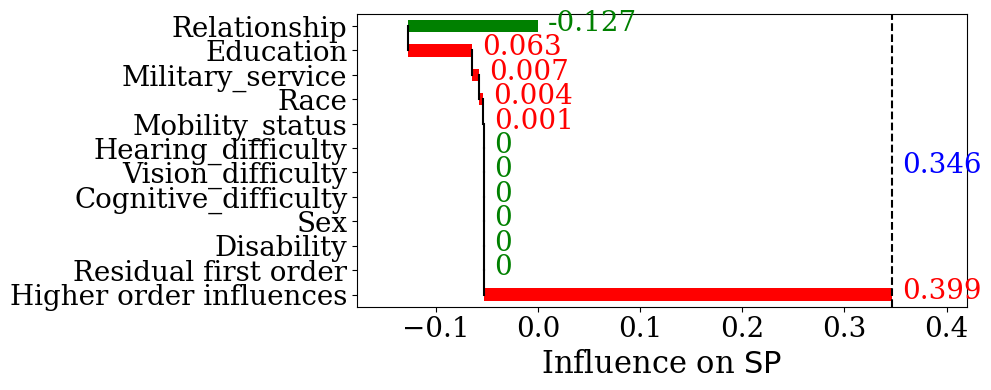

Exact statistical parity 0.38624419079841477


<Figure size 1000x400 with 0 Axes>

In [16]:
k = 10
fairXplainer_result = fairXplainer.get_weights(k=k)
plt = fif_plot(fairXplainer_result, 
               draw_waterfall=True, 
               labelsize=labelsize, 
               figure_size=(10,4), 
               text_y_pad=0.2, 
               xlim=None, 
               result_x_pad=0.02,
               x_label="Influence on " + r"$ \mathsf{SP} $"
        )
plt.tight_layout()
plt.show()
plt.clf()

print("Exact statistical parity", fairXplainer.statistical_parity_sample())

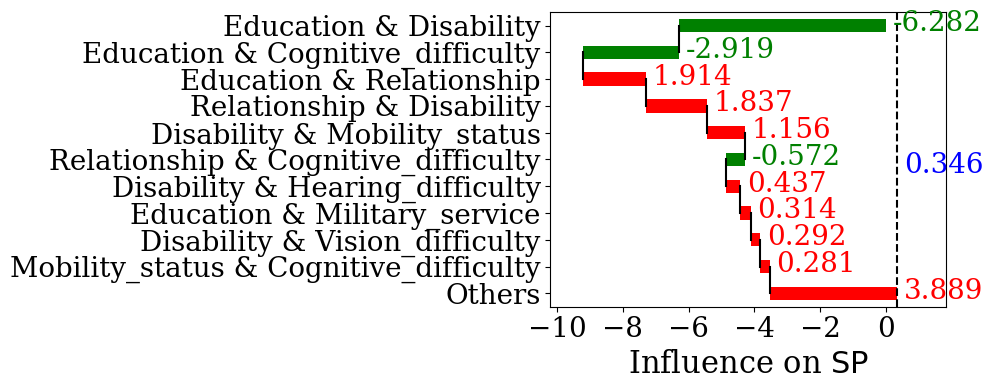

Exact statistical parity 0.38624419079841477


<Figure size 1000x400 with 0 Axes>

In [24]:
k = 10
fairXplainer_result = fairXplainer.get_top_k_weights(k=k)

plt = fif_plot(fairXplainer_result, 
               draw_waterfall=True, 
               labelsize=labelsize, 
               figure_size=(10,4), 
               text_y_pad=0.2, 
               xlim=None, 
               result_x_pad=0.02,
               x_label="Influence on " + r"$ \mathsf{SP} $"
        )
plt.tight_layout()
plt.show()
plt.clf()

print("Exact statistical parity", fairXplainer.statistical_parity_sample())

## Improving Fairness By a Pre-processing Fairness Algorithm

In [25]:
encoded_df_train = X_train.copy()
encoded_df_train['target'] = y_train

encoded_df_test = X_test.copy()
encoded_df_test['target'] = y_test


binary_label_dataset_train = aif360.datasets.BinaryLabelDataset(
    favorable_label=0,
    unfavorable_label=1,
    df=encoded_df_train,
    label_names=['target'],
    protected_attribute_names=['Sex'])
binary_label_dataset_test = aif360.datasets.BinaryLabelDataset(
    favorable_label=0,
    unfavorable_label=1,
    df=encoded_df_test,
    label_names=['target'],
    protected_attribute_names=['Sex'])


if(False):
    # Disparate Impact Remover
    di = DisparateImpactRemover(repair_level = 1.0)
    di.fit(binary_label_dataset_train)

    dataset_transf_train = di.fit_transform(binary_label_dataset_train).convert_to_dataframe()[0]
    dataset_transf_test = di.fit_transform(binary_label_dataset_test).convert_to_dataframe()[0]


else:
    # Reweighing
    rw = Reweighing(unprivileged_groups=[{'Sex' : 1}], privileged_groups=[{'Sex' : 0}])
    rw.fit(binary_label_dataset_train)

    binary_label_dataset_trans_train = rw.transform(binary_label_dataset_train)
    dataset_transf_train = binary_label_dataset_trans_train.convert_to_dataframe()[0]
    dataset_transf_test = rw.transform(binary_label_dataset_test).convert_to_dataframe()[0]

X_trans_train = dataset_transf_train.drop(['target'], axis = 1)
y_trans_train = dataset_transf_train['target']


X_trans_test = dataset_transf_test.drop(['target'], axis = 1)
y_trans_test = dataset_transf_test['target']



Training after fairness repair

In [26]:
model_trans, model_trans_name = LogisticRegression(solver='lbfgs', max_iter=10000), "lr"
model_trans.fit(X_trans_train, y_trans_train, sample_weight= binary_label_dataset_trans_train.instance_weights)

LogisticRegression(max_iter=10000)

Validating fairness repair using Justicia

## Explaining the Sources of Bias

In [32]:
fairXplainer_trans = FairXplainer(model_trans, X_trans_test, ['Sex', 'Marital_status'])
fairXplainer_trans.compute(maxorder=2, spline_intervals=3, verbose=False, maxiter=10, cpu_time=1000)

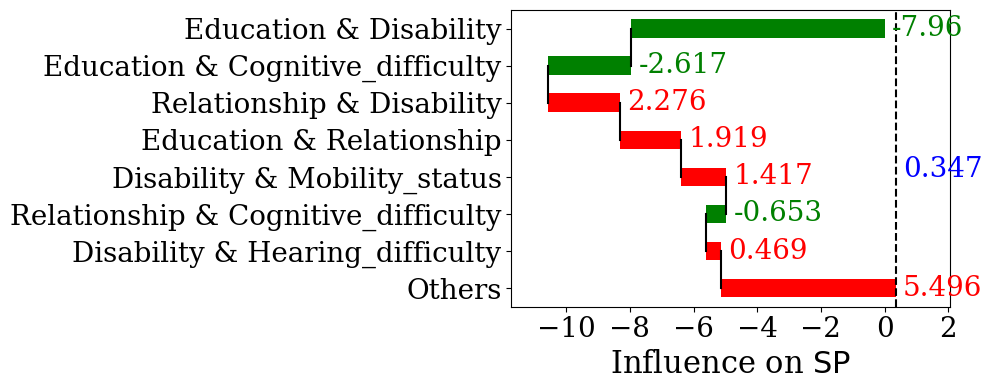

Exact statistical parity 0.376027599053421


<Figure size 1000x400 with 0 Axes>

In [33]:
k = 7
fairXplainer_trains_result = fairXplainer_trans.get_top_k_weights(k=k)

plt = fif_plot(fairXplainer_trains_result, 
               draw_waterfall=True, 
               labelsize=labelsize, 
               figure_size=(10,4), 
               text_y_pad=0.2, 
               xlim=None, 
               result_x_pad=0.02,
               x_label="Influence on " + r"$ \mathsf{SP} $"
)
plt.tight_layout()
plt.show()
plt.clf()

print("Exact statistical parity", fairXplainer_trans.statistical_parity_sample())